# Tissue mechanics in FEniCS

This lecture is based on the [FEniCS tutorials](https://fenicsproject.org/pub/tutorial/html/._ftut1001.html#table_of_contents).

In [2]:
%matplotlib inline

from fenics import *
import matplotlib.pyplot as plt

## Introduction: Linear elasticity

Linear elasticity deals with the equations governing small elastic deformations following a linear relationship between stress and strain. Nonlinear stress-strain relationships are goverened by the hyperelastic equations, which are introduced in the Cardiac Tissue Mechanics and Fluid Dynamics stream of the Summer School.

The momentum balance equation for small elastic deformations of a body $\Omega$ reads

$$-\nabla \cdot \sigma = f \qquad \text{in } \Omega$$

with stress tensor $\sigma$, elasticity tensor $\varepsilon$ and body force per unit volume $f(\boldsymbol{x})$. 

$$\sigma = \lambda \; tr(\varepsilon) I + 2 \mu \varepsilon$$
$$\varepsilon = \frac{1}{2} (\nabla u + (\nabla u)^T)$$

The stress tensor depends on two parameters that are specific for every material, the Lamè constants $\lambda$ and $\mu$. The trace operator $tr(A)$ represents the sum of the elements on the main diagonal of a tensor $A$, $I$ is the identity tensor, and $u(\boldsymbol{x})$ is the displacement vector field. Inserting the definition of $\varepsilon$ into $\sigma$ gives

$$\sigma = \lambda (\nabla \cdot u) I + \mu (\nabla u + (\nabla u)^T)$$

Note that while we have written the momentum balance equation in terms of the stress tensor $\sigma$, our primary unknown is the displacement vector field $u$.

### Variational form

Deriving the variational form requires multiplication of the governing equation by a test function $v \in \hat{V}$, integrating over the domain $\Omega$.

$$- \int_{\Omega} (\nabla \cdot \sigma) \cdot v dx = \int_{\Omega} f \cdot v dx$$

Note that this time, as our unknown $u$ is vector-valued, our test function $v$ is also vector-valued. Note also from the definition of $\sigma$ that the term $\nabla \cdot \sigma$ contains second-order derivatives of $u$, so we integrate this term by parts

$$- \int_{\Omega} (\nabla \cdot \sigma) \cdot v dx = \int_{\Omega} \sigma : \nabla v dx - \int_{\partial \Omega} (\sigma \cdot n) \cdot v ds$$

where the colon operator denotes the *inner product* between two tensors:

$$A : B = \sum_i \sum_j A_{ij} B_{ij} = A_{11} B_{11} + A_{12} B_{12} + \ldots$$

The term $\sigma \cdot n$ denotes traction or stress at the boundary in the outward normal direction of the boundary and is often prescribed as a boundary condition. In fluid-structure interaction problems such as the deformation of an arterial wall due to the oscillating blood pressure, the boundary traction is directly proportional to the fluid pressure $\sigma \cdot n = -p n$. Here, we assume that traction is prescribed on some part $\partial \Omega_T$ of the boundary as $\sigma \cdot n = T$. On the remaining boundary we assume that displacement is prescribed using a Dirichlet boundary condition. The variational form thus reads

$$\int_{\Omega} \sigma : \nabla v dx = \int_{\Omega} f \cdot v dx - \int_{\partial \Omega_T} T \cdot v ds$$

or

$$a(u,v) = L(v) \qquad \forall v \in \hat{V}$$

where

$$a(u,v) = \int_{\Omega} \sigma : \nabla v dx$$
$$\sigma = \lambda (\nabla \cdot u) I + \mu (\nabla u + (\nabla u)^T)$$
$$L(v) = \int_{\Omega} f \cdot v dx - \int_{\partial \Omega_T} T \cdot v ds$$

The inner product of a symmetric tensor $A$ with an antisymmetric tensor $B$ vanishes. By expressing $\nabla v$ as a sum of its symmetric and antisymmetric parts it is thus possible to simplify the term $\sigma : \nabla v$ since $\sigma$ is always a symmetric tensor to obtain

$$a(u,v) = \int_{\Omega} \sigma : \varepsilon(v) dx$$

where

$$\varepsilon(v) = \frac{1}{2} (\nabla v + (\nabla v)^T)$$

is the symmetric part of $\nabla v$.

### FEniCS implementation

In [25]:
from fenics import *
from ufl import nabla_div
from mshr import *

import numpy as np
import matplotlib.pylab as plt

As an example, we will consider the elastic deformation of the wall of an artery, represented by an axisymmetric cylindrical tube. 

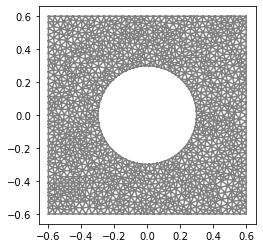

In [26]:
# Create mesh
W_i = 0.3
W_o = 0.6
c1 = Circle(Point(0,0), W_i)
c2 = Rectangle(Point(-W_o, -W_o), Point(W_o, W_o))
geo = c2-c1
mesh = generate_mesh(geo, 32)
plot(mesh)
ref_mesh = generate_mesh(geo, 32)

In [27]:
# Define function space
V = VectorFunctionSpace(mesh, 'P', 1)

# Define elasticity parameters
mu = 2
lam = 100

We have previously implemented Dirichlet boundary conditions using functions, and while functions work well for Dirichlet boundary conditions, we can't implement Neumann boundary conditions in this way. A more general approach to implementing boundary conditions is provided using a MeshFunction. A MeshFunction allows you to mark parts of a domain's boundary using labels that can then be used to apply boundary conditions.

In [28]:
# Instantiate a boundary MeshFunction using integers as lables
boundaries = MeshFunction('size_t', mesh, mesh.topology().dim()-1)
boundaries.set_all(0)

Boundary conditions now have to be implemented as a class inheriting from the FEniCS class SubDomain

To apply the boundary conditions we write

In [32]:
class Pressure(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0]**2.0+x[1]**2.0, W_i**2.0, 0.5*mesh.hmin())
    
class NoDeformation(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and (x[0]**2.0+x[1]**2.0)>W_i**2.0+2.0*mesh.hmin()

pressure = Pressure()
pressure.mark(boundaries, 1)

nodeformation = NoDeformation()
nodeformation.mark(boundaries, 2)

ds = Measure('ds', subdomain_data=boundaries)

bc = DirichletBC(V, u_D, boundaries, 2)

In [33]:
# Define strain and stress
def epsilon(u):
    return 0.5*(nabla_grad(u) + nabla_grad(u).T)

def sigma(u, d):
    return lam*nabla_div(u)*Identity(d) + 2*mu*epsilon(u)

#### Exercise: Implement the variational form for the linear elastic problem. Fluid pressure in the artery is 80 mmHg $\approx$ 10500 Pa on the inner boundary of the wall

In [34]:
# Define variational problem
# insert code here
u = TrialFunction(V)
v = TestFunction(V)
d = u.geometric_dimension()  # space dimension
n = FacetNormal(mesh)
p_D = Constant(10.500)
T = Constant(p_D) * n
f = Constant((0.0, 0.0))
a = inner(sigma(u, d), epsilon(v))*dx
L = dot(f, v)*dx - dot(T, v)*ds(1)

# Compute solution
u = Function(V)
solve(a == L, u, bc)

# Save solution
u_file = XDMFFile("linear_elasticity/du.xdmf")
u_file.write_checkpoint(u, 'displacement', 0.0)
u_file.close()

#  Export stess
s = sigma(u, d) - (1/3)*tr(sigma(u, d))*Identity(d)  # deviatoric stress
von_Mises = sqrt(3/2*inner(s, s))
W = FunctionSpace(mesh, 'P', 1)
von_Mises = project(von_Mises, W)
s_file = XDMFFile("linear_elasticity/von_mises.xdmf")
s_file.write_checkpoint(von_Mises, 'stress', 0.0)
s_file.close()

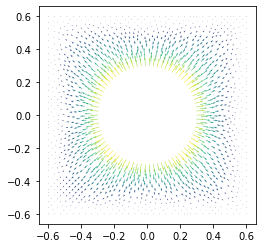

In [35]:
plot(u)

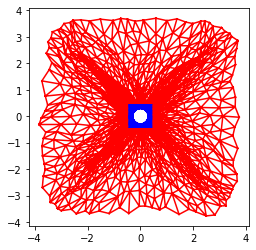

In [196]:
ALE.move(mesh, u)
plot(ref_mesh, color="blue")
plot(mesh, color="red")